In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics
from sklearn.model_selection import KFold
from keras import models, layers
from python_project import database_interaction as db
from python_project import connect_database
from dataset import Dataset

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rajat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rajat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rajat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rajat\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = db.get_dataframe()
df_org = df.copy()

4.0.0.6816


In [11]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

# configuration
cloud_config= {
        'secure_connect_bundle': r"C:\Users\rajat\Downloads\secure-connect-news-articles.zip"
}

# authentication details
auth_provider = PlainTextAuthProvider('KQXuSjNiyLpIXJSpjwhZHSmD', 'ilouHT6e.xn_LaXhxZ-WAdi0wwR-2.wQFe.-0Nawqv+TDAEO+RF-cZe9WrLzPB+_26eKQWBLgbAO61l5.RtYqqS2GPsmZTNe0,fTFJlIo7+Um+pRKWtUOA8-0Qgr0edl')

# connecting to cluster using configuration and authentication details
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

# using the session we can execute commands on the cassandra database
row = session.execute("select release_version from system.local").one()

# checking for a successful query
if row:
    print(row[0])
else:
    print("An error occurred.")

ERROR:cassandra.connection:Closing connection <AsyncoreConnection(2483437350584) 30f9ec55-8e9a-4b98-944e-bdc3e4b7d43b-asia-south1.db.astra.datastax.com:29042:379d8a64-3a1e-4e89-882e-dc4b809a0c57> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"


4.0.0.6816


In [12]:
row = session.execute("SELECT * FROM news_articles.train_2").all()

In [3]:
df

,article_id,news,category
0,1584,alicia keys to open us super bowl r&b star ali...,entertainment
1,1863,johnson uncertain about euro bid jade johnson ...,sport
2,1765,nintendo ds aims to touch gamers the mobile ga...,tech
3,2062,turkey deal to help world peace a deal bring...,politics
4,1199,sales fail to boost high street the january ...,business
...,...,...,...
1485,2086,mobile games come of age the bbc news website ...,tech
1486,232,mrs howard gets key election role michael howa...,politics
1487,1843,mitsubishi in peugeot link talks trouble hit m...,business
1488,986,cup holders man utd visit everton holders manc...,sport


In [4]:
dataset = Dataset(df, num_words=2000)
x_train = dataset.get_train_data()
df = df_org.copy()
y_train = dataset.get_labels(dataframe=df, target='category')

In [5]:
x_train

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [6]:
# cross-validate 
kf = KFold(n_splits=6, shuffle=True, random_state=42)

In [7]:
fold = 0
oos_y = list()
oos_pred = list()
all_scores = list()

for train, test in kf.split(x_train):
    
    fold += 1
    print(f"Fold Number: {fold}")
#     print(train.shape)
#     print(test)
    x_train_fold = x_train[train]
    y_train_fold = y_train[train]
    x_test_fold = x_train[test]
    y_test_fold = y_train[test]
    
    model = models.Sequential([
        layers.Dense(6, activation='relu', input_shape=(2000,)),
        layers.Dense(8, activation='relu'),
        layers.Dense(5, activation='softmax')
    ])
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['acc'])
    
    history = model.fit(
    x_train_fold, 
    y_train_fold,
    epochs=10,
    batch_size=1,
    verbose=0,
    validation_data=(x_test_fold, y_test_fold)
    )
    
    pred = model.predict(x_test_fold)
    pred_comp = np.argmax(pred, axis=1)
    
#     oos_y.append(y_test_fold)
#     oos_pred.append(pred)
    
    y_test_comp = np.argmax(y_test_fold, axis=1)
    
    oos_y.append(y_test_comp)
    oos_pred.append(pred_comp)
    
    # Measuring this fold's RMSE
    # cce = tf.keras.losses.CategoricalCrossentropy()
    # print(f"Loss for Fold {fold} : {cce(y_test_fold, pred).numpy()}")
    score = metrics.accuracy_score(y_test_comp, pred_comp)
    print(f"Loss for Fold {fold} : {score}")
    all_scores.append(score)
    
# Build the oos prediction list and calculate the error
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)

# cce = tf.keras.losses.CategoricalCrossentropy()
# print(f"Total Loss Computed : {cce(oos_y, oos_pred).numpy()}")
score = np.array(all_scores).mean()
print(f"\n\nTotal loss computed : {score}")

Fold Number: 1
Loss for Fold 1 : 0.9598393574297188
Fold Number: 2
Loss for Fold 2 : 0.9397590361445783
Fold Number: 3
Loss for Fold 3 : 0.9798387096774194
Fold Number: 4
Loss for Fold 4 : 0.9596774193548387
Fold Number: 5
Loss for Fold 5 : 0.9798387096774194
Fold Number: 6
Loss for Fold 6 : 0.9838709677419355


Total loss computed : 0.9671373666709849


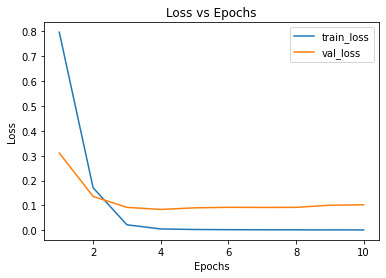

In [8]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')

plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

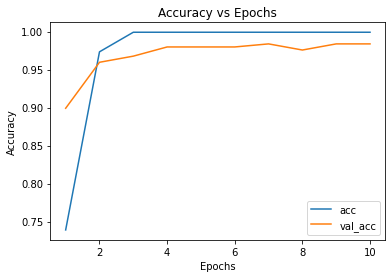

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, label='acc')
plt.plot(epochs, val_acc, label='val_acc')

plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Final Model Training

In [69]:
# model = models.Sequential([
#         layers.Dense(6, activation='relu', input_shape=(2000,)),
#         layers.Dense(8, activation='relu'),
#         layers.Dense(5, activation='softmax')
# ])

# opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# model.compile(optimizer=opt,
# loss='categorical_crossentropy',
# metrics=['acc'])

In [44]:
y_train

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [10]:
history = model.fit(
x_train, 
y_train,
epochs=10,
batch_size=1
)

Epoch 1/10
1490/1490 [==============================] - 3s 2ms/step - loss: 0.0231 - acc: 0.9953
Epoch 2/10
1490/1490 [==============================] - 3s 2ms/step - loss: 0.0049 - acc: 0.9993
Epoch 3/10
1490/1490 [==============================] - 4s 2ms/step - loss: 0.0035 - acc: 0.9993
Epoch 4/10
1490/1490 [==============================] - 4s 3ms/step - loss: 0.0018 - acc: 0.9993
Epoch 5/10
1490/1490 [==============================] - 4s 3ms/step - loss: 9.6674e-04 - acc: 0.9993
Epoch 6/10
1490/1490 [==============================] - 4s 2ms/step - loss: 0.0011 - acc: 0.9993
Epoch 7/10
1490/1490 [==============================] - 3s 2ms/step - loss: 9.7811e-04 - acc: 0.9993
Epoch 8/10
1490/1490 [==============================] - 4s 3ms/step - loss: 9.6005e-04 - acc: 0.9993
Epoch 9/10
1490/1490 [==============================] - 4s 3ms/step - loss: 8.1899e-04 - acc: 0.9993
Epoch 10/10
1490/1490 [==============================] - 4s 2ms/step - loss: 7.3640e-04 - acc: 0.9993


# Making Predictions On Test Data

In [11]:
test = pd.read_csv('test.csv')

test.rename(columns = {'text':'news'}, inplace = True)

test['news'] = test['news'].apply(dataset.preprocess)

In [12]:
# getting tokenizer on which the train dataset was trained!! 
# not training a separate tokenizer for test dataset

tokenizer = dataset.get_tokenizer()

In [13]:
x_test_seq = dataset.convert_texts_to_sequences(test)

x_test = dataset.vectorize_sequences(x_test_seq)

In [14]:
predictions = model.predict(x_test)

In [15]:
df = df_org.copy()

In [16]:
df.head()

,article_id,news,category
0,1584,alicia keys to open us super bowl r&b star ali...,entertainment
1,1863,johnson uncertain about euro bid jade johnson ...,sport
2,1765,nintendo ds aims to touch gamers the mobile ga...,tech
3,2062,turkey deal to help world peace a deal bring...,politics
4,1199,sales fail to boost high street the january ...,business


In [17]:
# label_encoder object knows how to understand word labels.
label_encoder = dataset.get_labels(df, target='category', get_encoder_only=True)

In [18]:
category_number = [np.argmax(x) for x in predictions]
names = label_encoder.inverse_transform(category_number)
preds = pd.DataFrame({'ArticleId': test['article_id'], 'Category': names})

In [19]:
preds.to_csv('submission_news.csv', index=False)

In [20]:
preds.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport


## Preprocess Layer

In [ ]:
sample_sequence = dataset.convert_texts_to_sequences(sample_news, text_only=True)

# sequences = self.tokenizer.texts_to_sequences(list(dataframe))
#
#

sample_test = dataset.vectorize_sequences(sample_sequence)

# results = np.zeros((len(sequences), self.dimension))

#         for i, sequence in enumerate(sequences):
#             results[i, sequence] = 1.0

predictions = model.predict(sample_test)

In [ ]:
class PreprocessLayer(keras.layers.Layer):
    
    def adapt(self, data_sample, dimension=2000):
        
        with open('tokenizer.pickle', 'rb') as handle:
            tokenizer = pickle.load(handle)
        
        dataset = Dataset(data_sample, num_words=2000)
        data_sample = data_sample[0].apply(dataset.preprocess)
        sequences = tokenizer.texts_to_sequences(data_sample)
        results = np.zeros((len(sequences), dimension))
        for i, sequence in enumerate(sequences):
            results[i, sequence] = 1.0
        self.result = results
        
    def call(self, inputs):
        return self.result

In [ ]:
list_of_news = pd.DataFrame(list(df['news']))

In [ ]:
pre_layer = PreprocessLayer()
pre_layer.adapt(list_of_news)

In [ ]:
pre_layer.result

In [ ]:
df['news']

In [ ]:
x_train_news = list(df['news'])
y_train_news = list(df['category'])

In [ ]:
x_train_news

In [ ]:
model = models.Sequential([
    pre_layer,
    layers.Dense(6, activation='relu', input_shape=(2000,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(5, activation='softmax')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
loss='categorical_crossentropy',
metrics=['acc'])

In [ ]:
model.build((2000,))

In [ ]:
model.summary()

In [ ]:
history = model.fit(
x_train_news, 
y_train_news,
epochs=10,
batch_size=1,
verbose=0,
# validation_data=(x_test_fold, y_test_fold)
)

## Making a single prediction

In [21]:
import pickle

In [21]:
import os
os.getcwd()

'/home/rajat/Projects/iNeuron/News/News-Article-Sorting'

In [22]:
os.listdir(os.getcwd())

['Model 4.ipynb',
 '.ipynb_checkpoints',
 'news_classification_model',
 'logs.txt',
 'python_project',
 'train.csv',
 'token.txt',
 'tokenizer.pickle',
 'test.csv',
 '.git',
 'preprocess.py',
 'Model.ipynb',
 'submission_news.csv',
 'dataset.py',
 'Database Interaction Notebook.ipynb',
 'Model 3.ipynb',
 '__pycache__',
 '.gitignore',
 'README.md',
 'preprocess_layer.py',
 'label_encoder.pickle',
 'EDA.ipynb',
 'Model 2.ipynb']

In [23]:
infile = open('tokenizer.pickle', 'rb')
tokenizer = pickle.load(infile)
# infile.close()

In [22]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)
    

In [25]:
input_news = 'qpr keeper day head preston queen park ranger keeper chris day set join preston month loan day displaced arrival simon royce second month loan charlton qpr also signed italian generoso rossi r manager ian holloway said might say risk recalled month simon royce recalled charlton iron fire yes couple others need day ranger contract expires summer meanwhile holloway hoping complete signing middlesbrough defender andy davy either permanently loan saturday match ipswich davy impressed recent loan spell loftus road holloway also chasing bristol city midfielder tom doherty'


In [ ]:
preprocess_layer = PreprocessLayer()
preprocess_layer.adapt(input_news)

In [91]:
sample_news = ['qpr keeper day head preston queen park ranger keeper chris day set join preston month loan day displaced arrival simon royce second month loan charlton qpr also signed italian generoso rossi r manager ian holloway said might say risk recalled month simon royce recalled charlton iron fire yes couple others need day ranger contract expires summer meanwhile holloway hoping complete signing middlesbrough defender andy davy either permanently loan saturday match ipswich davy impressed recent loan spell loftus road holloway also chasing bristol city midfielder tom doherty']

In [92]:
sample_news

['qpr keeper day head preston queen park ranger keeper chris day set join preston month loan day displaced arrival simon royce second month loan charlton qpr also signed italian generoso rossi r manager ian holloway said might say risk recalled month simon royce recalled charlton iron fire yes couple others need day ranger contract expires summer meanwhile holloway hoping complete signing middlesbrough defender andy davy either permanently loan saturday match ipswich davy impressed recent loan spell loftus road holloway also chasing bristol city midfielder tom doherty']

In [97]:
# sample_sequence = dataset.convert_texts_to_sequences(sample_news)
# sample_test = dataset.vectorize_sequences(sample_sequence)
# predictions = model.predict(sample_test)

In [ ]:
sample_test

In [ ]:
predictions

In [ ]:
prediction_category = predictions[0].argmax()

In [90]:
label_encoder.inverse_transform([prediction_category])[0]

NameError: name 'prediction_category' is not defined

In [23]:
with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('label_encoder.pickle', 'rb') as handle:
#     label_encoder = pickle.load(handle)

In [31]:
model_version = "0003"
model_name = "news_classification_model"
model_path = os.path.join(model_name, model_version)

model_path

'news_classification_model/0003'

In [37]:
model.save('news_classification_model_4.h5')

In [38]:
saved_model = keras.models.load_model('news_classification_model_4.h5')

In [26]:
from preprocess import (
    lower_case,
    remove_special_characters,
    remove_stopwords,
    concatenate,
    lemmatize,
)


In [27]:
def preprocess_text(inputs, dimension=2000):
    
    inputs = lower_case(inputs)
    inputs = remove_special_characters(inputs)
    inputs = remove_stopwords(inputs)
    inputs = concatenate(inputs)
    inputs = lemmatize(inputs)
    
    inputs = [inputs]
    
    sequences = tokenizer.texts_to_sequences(inputs)
    
    results = np.zeros((len(sequences), dimension))
    
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.0
    
    return results

In [45]:
sample_news = """
The Indian economy has “some bright spots and a number of very dark stains” and the government should target its spending “carefully” so that there are no huge deficits, noted economist and former RBI Governor Raghuram Rajan said on Sunday.

Known for his frank views, Dr. Rajan also said the government needed to do more to prevent a K-shaped recovery of the economy hit by the coronavirus pandemic.

Generally, a K-shaped recovery will reflect a situation where technology and large capital firms recover at a far faster rate than small businesses and industries that have been significantly impacted by the pandemic.

“My greater worry about the economy is the scarring to the middle class, the small and medium sector, and our children’s minds, all of which will come into play after an initial rebound due to pent up demand. One symptom of all this is weak consumption growth, especially for mass consumption goods,” Dr. Rajan told PTI in an e-mail interview.
"""

In [46]:
inputs = preprocess_text(sample_news)

In [47]:
y_pred = saved_model(inputs)

In [48]:
y_pred

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[9.7538096e-01, 1.9016330e-03, 7.2072871e-06, 1.5101174e-06,
        2.2708649e-02]], dtype=float32)>

In [49]:
category = saved_model.predict(inputs)
# category = model(inputs, training=False, name=model.)

In [50]:
def result(category):
    return label_encoder.inverse_transform([category[0].argmax()])[0]

In [51]:
result(category)

'business'

In [ ]:
model_name = 'news_classification_model'

In [ ]:
from tensorflow_serving.apis.predict_pb2 import PredictRequest

In [ ]:
request = PredictRequest()
request.model_spec.name = model_name
request.model_spec.signature_name = "serving_default"
input_name = model.input_names[0]
request.inputs[input_name].CopyFrom(tf.make_tensor_proto(sample_news))

In [ ]:
import grpc
from tensorflow_serving.apis import prediction_service_pb2_grpc

In [ ]:
channel = grpc.insecure_channel('localhost:5005', options=(('grpc.enable_http_proxy', 0),))
predict_service = prediction_service_pb2_grpc.PredictionServiceStub(channel)
response = predict_service.Predict(request, timeout=60.0)

In [ ]:
response

In [ ]:
model.summary()